In [ ]:
pip install shap

In [1]:
# Step 0: Import necessary libraries
# We'll need pandas for data manipulation, sklearn for data and splitting,
# and of course xgboost itself.
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Optional: For advanced model interpretation (Step 5)
try:
    import shap
except ImportError:
    print("SHAP library not found. Please install it for Step 5: pip install shap")
    shap = None

print(f"XGBoost version: {xgb.__version__}")

SHAP library not found. Please install it for Step 5: pip install shap
XGBoost version: 2.1.4


In [4]:
# --- Step 1: Data Preparation ---
# Instead of a housing dataset, we'll create a synthetic fisheries dataset.
# Our goal is to predict fish abundance (Catch Per Unit Effort - CPUE)
# based on common environmental variables from a trawl survey.

def create_fisheries_data(n_samples=2000):
    """Generates a synthetic dataset for predicting fish CPUE."""
    np.random.seed(42)
    
    # Environmental Features
    bottom_temp = np.random.uniform(2, 15, n_samples)
    salinity = np.random.uniform(28, 35, n_samples)
    depth = np.random.uniform(20, 200, n_samples)
    day_of_year = np.random.randint(60, 150, n_samples) # March to May
    
    # Create a non-linear relationship between temperature and CPUE (dome-shaped)
    # Fish have an optimal temperature range.
    temp_effect = -0.1 * (bottom_temp - 8)**2
    
    # Other linear effects
    salinity_effect = 0.05 * salinity
    depth_effect = -0.01 * depth
    
    # Add some noise
    noise = np.random.normal(0, 0.5, n_samples)
    
    # Calculate a base CPUE and ensure it's non-negative
    base_cpue = 10 + temp_effect + salinity_effect + depth_effect + noise
    base_cpue[base_cpue < 0] = 0
    
    # It's common practice to log-transform CPUE to handle zeros and skewness
    y = np.log1p(base_cpue)
    
    X = pd.DataFrame({
        'BottomTemp': bottom_temp,
        'Salinity': salinity,
        'Depth': depth,
        'DayOfYear': day_of_year
    })
    
    return X, y

print("\n--- Step 1: Creating and Preparing Fisheries Data ---")
X_df, y = create_fisheries_data()
feature_names = X_df.columns.tolist()

# Split data into training and validation sets. This is crucial for using
# early stopping later on.
X_train, X_val, y_train, y_val = train_test_split(X_df, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print("Example features:\n", X_train.head())


--- Step 1: Creating and Preparing Fisheries Data ---
Training data shape: (1600, 4)
Validation data shape: (400, 4)
Example features:
      BottomTemp   Salinity       Depth  DayOfYear
968    9.363260  34.629635  192.284270        130
240   14.225962  33.562048  141.619322        131
819    6.357564  30.499205   55.859543        133
692    8.598935  28.069467   81.936491         74
420   12.290528  29.120175   37.716354        111


In [5]:
# --- Step 2: Model Initialization (The `mgcv::gam` Analogy) ---
# Here, we create an instance of the XGBoost model. This is like setting up
# your gam() call with its parameters before you actually fit it to data.
# We'll use XGBRegressor to predict the continuous log(CPUE+1) value.

print("\n--- Step 2: Initializing the XGBoost Model ---")

# Let's define the core parameters.
# mgcv::gam(log_cpue ~ s(BottomTemp, k=10) + s(Depth, k=10), sp=c(0.1, 0.5), ...)
# is analogous to...
xgb_reg = xgb.XGBRegressor(
    # --- Boosting Parameters (How the model learns) ---
    n_estimators=1000,         # Analogous to the "richness" of the model. Number of trees to build.
                               # We set this high and use early stopping to find the optimal number.
    learning_rate=0.05,        # Analogous to a shrinkage parameter. Lower values make the model more robust.

    # --- Tree Complexity Parameters (Analogous to `k` and `sp`) ---
    max_depth=5,               # Analogous to `k` in s(x, k=...). Controls max interaction depth.
    min_child_weight=1,        # A form of regularization. Prevents learning highly specific patterns.
    gamma=0.1,                 # Analogous to `sp`. A value > 0 penalizes splits, making the model more conservative.
    subsample=0.8,             # Use 80% of data for building each tree. Adds randomness to fight overfitting.
    colsample_bytree=0.8,      # Use 80% of features for building each tree. Also for overfitting.

    # --- Regularization Parameters (Directly analogous to `sp`) ---
    reg_alpha=0.005,           # L1 regularization on leaf weights.
    reg_lambda=1,              # L2 regularization on leaf weights.

    # --- Technical Parameters ---
    objective='reg:squarederror', # The loss function to optimize.
    n_jobs=-1,                 # Use all available CPU cores.
    random_state=42,           # For reproducibility.
    eval_metric='rmse'         # Metric to monitor during training.
)

print("Model initialized with parameters:")
print(xgb_reg.get_params())


--- Step 2: Initializing the XGBoost Model ---
Model initialized with parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.005, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [11]:
print("\n--- Step 3: Training the Model with Early Stopping ---")

# The `eval_set` is used for early stopping.
# XGBoost will calculate the RMSE on the validation set after each tree is added.
# If the RMSE doesn't improve for `early_stopping_rounds`, training stops.
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False) # Set verbose=True to see the training progress

print(f"Model training complete.")
# FIX: Access the evaluation results dictionary which is always available.
# The .best_iteration and .best_score attributes are only set if early stopping
# is actually triggered. This is a more robust way to get the results.
results = xgb_reg.evals_result()
best_iteration = np.argmin(results['validation_0']['rmse'])
best_score = results['validation_0']['rmse'][best_iteration]

print(f"Best iteration found: {best_iteration}")
print(f"Best validation RMSE: {best_score:.4f}")


--- Step 3: Training the Model with Early Stopping ---
Model training complete.
Best iteration found: 992
Best validation RMSE: 0.0582


In [12]:
# --- Step 4: Making Predictions ---
# This is straightforward, just like `predict.gam`.
# The model automatically uses the optimal number of trees found during early stopping.

print("\n--- Step 4: Making Predictions ---")
predictions = xgb_reg.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Final RMSE on validation data: {rmse:.4f}")


--- Step 4: Making Predictions ---
Final RMSE on validation data: 0.0582



--- Step 5: Interpreting the Model ---
Plotting feature importance...


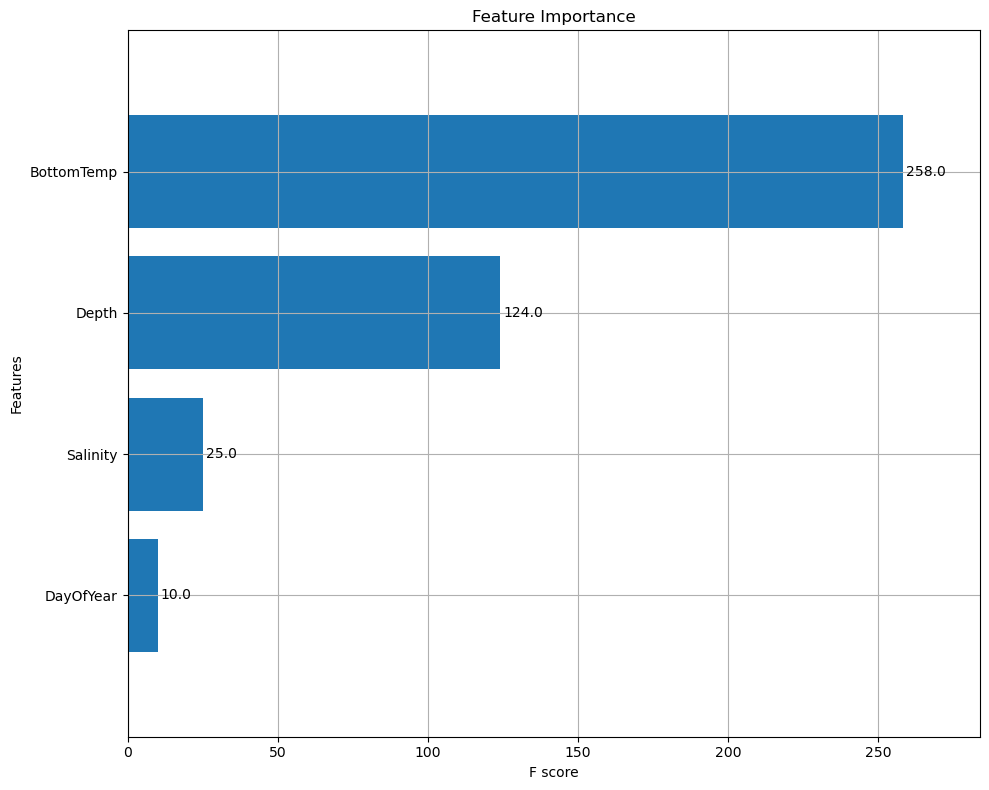


Skipping SHAP plots as the 'shap' library is not installed.


In [13]:


# --- Step 5: Model Interpretation (The `mgcv::plot.gam` Analogy) ---
# We can't plot smooths, but we can get powerful insights.

print("\n--- Step 5: Interpreting the Model ---")

# 5a. Feature Importance
# This is like looking at the p-values in `summary.gam`. It tells you which
# environmental variables the model used most to predict CPUE.
print("Plotting feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=ax, max_num_features=10, height=0.8, title="Feature Importance")
plt.tight_layout()
plt.show()


# 5b. SHAP Values (Advanced but powerful!)
# This is the modern equivalent of partial dependence plots or `plot.gam`.
# It explains *how* each feature impacts the prediction for every single survey point.
if shap:
    print("\nCalculating and plotting SHAP values...")
    # Create a SHAP explainer object
    explainer = shap.TreeExplainer(xgb_reg)

    # Calculate SHAP values for the validation set
    shap_values = explainer.shap_values(X_val)

    # Summary plot: Shows the distribution of impacts for each feature.
    # Red means high feature value, blue means low.
    # Points to the right increase the prediction, points to the left decrease it.
    shap.summary_plot(shap_values, X_val, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot for Fisheries Data")
    plt.tight_layout()
    plt.show()

    # Dependence plot: Shows the effect of a single feature across the whole dataset.
    # This is the closest thing to a partial effect plot from a GAM.
    # It shows how the predicted log(CPUE+1) changes as 'BottomTemp' changes.
    # We can clearly see the dome-shaped relationship we created!
    shap.dependence_plot("BottomTemp", shap_values, X_val, show=False)
    plt.title("SHAP Dependence Plot for Bottom Temperature")
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping SHAP plots as the 'shap' library is not installed.")